In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp
import scipy.stats as stats 

In [2]:
#Cargar los datos reales y sinteticos
df_real = pd.read_csv('final_static_data_basic.csv',index_col=0)
df_synth = pd.read_csv('final_static_basic_augmented.csv',index_col=0)

In [3]:
print(df_real.columns)
print(df_synth.columns)

Index(['MMSI', 'draught', 'to_bow', 'to_stern', 'to_port', 'to_starboard',
       'shiptype'],
      dtype='object')
Index(['MMSI', 'draught', 'to_bow', 'to_stern', 'to_port', 'to_starboard',
       'shiptype'],
      dtype='object')


In [4]:
# Eliminar las columnas 'MMSI' 
df_real_limpio = df_real.drop(columns=['MMSI'])
df_synth_limpio = df_synth.drop(columns=['MMSI'])

In [5]:
print(df_real_limpio.columns)
print(df_synth_limpio.columns)

Index(['draught', 'to_bow', 'to_stern', 'to_port', 'to_starboard', 'shiptype'], dtype='object')
Index(['draught', 'to_bow', 'to_stern', 'to_port', 'to_starboard', 'shiptype'], dtype='object')


In [6]:
print("Tipos de barco en datos reales:", df_real["shiptype"].unique())
print("Tipos de barco en datos sintéticos:", df_synth["shiptype"].unique())

Tipos de barco en datos reales: ['ShipType.Tug' 'ShipType.Fishing' 'ShipType.Cargo' 'ShipType.Passenger'
 'ShipType.Tanker']
Tipos de barco en datos sintéticos: ['ShipType.Tug' 'ShipType.Fishing' 'ShipType.Cargo' 'ShipType.Passenger'
 'ShipType.Tanker']


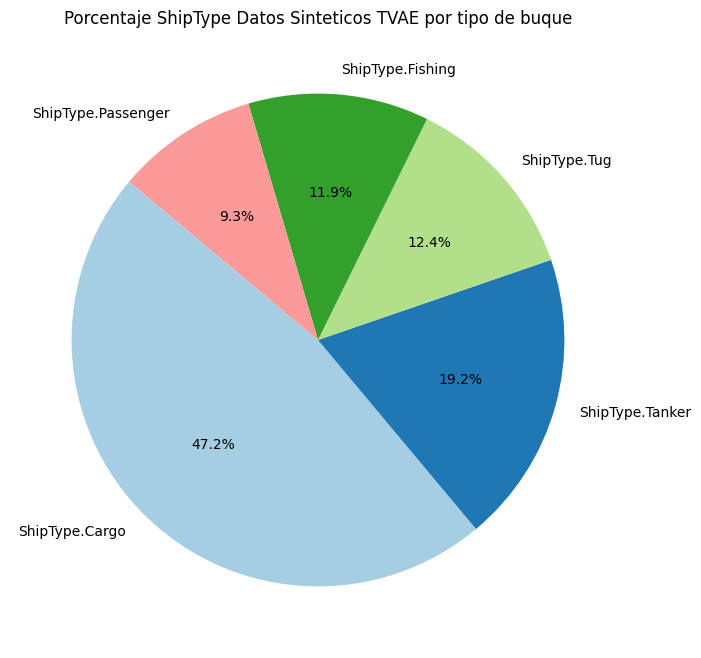

In [7]:
#Porcentaje de cada shiptype
shiptype_percentage = df_synth["shiptype"].value_counts(normalize=True) * 100

import matplotlib.pyplot as plt
# Crear el gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(shiptype_percentage, labels=shiptype_percentage.index, autopct="%1.1f%%", startangle=140, colors=plt.cm.Paired.colors)
plt.title("Porcentaje ShipType Datos Sinteticos TVAE por tipo de buque")
plt.show()

In [28]:
# Ver columnas disponibles
print("Columnas en df_real:", df_real.columns.tolist())
print("Columnas en df_synth:", df_synth.columns.tolist())

# Ver cuántos barcos 'Passenger' hay en cada uno
print("Barcos Passenger (reales):", (df_real['shiptype'] == 'ShipType.Passenger').sum())
print("Barcos Passenger (aumentados):", (df_synth['shiptype'] == 'ShipType.Passenger').sum())


Columnas en df_real: ['MMSI', 'draught', 'to_bow', 'to_stern', 'to_port', 'to_starboard', 'shiptype']
Columnas en df_synth: ['MMSI', 'draught', 'to_bow', 'to_stern', 'to_port', 'to_starboard', 'shiptype']
Barcos Passenger (reales): 2912
Barcos Passenger (aumentados): 4368


In [29]:
# Limpiar el campo 'shiptype' extrayendo solo el nombre (después del punto)
df_real['shiptype'] = df_real['shiptype'].astype(str).str.split('.').str[-1]
df_synth['shiptype'] = df_synth['shiptype'].astype(str).str.split('.').str[-1]


In [30]:
#Filtrar clase Passenger
real_passenger = df_real[df_real['shiptype'] == 'Passenger']
augmented_passenger = df_synth[df_synth['shiptype'] == 'Passenger']

In [39]:
# Variables numéricas comunes
variables_numericas = ['draught', 'to_bow', 'to_stern', 'to_port', 'to_starboard']

# Tabla estadística comparativa

resumen = []

for var in variables_numericas:
    real_vals = real_passenger[var].dropna()
    smote_vals = augmented_passenger[var].dropna()

    if real_vals.nunique() > 1 and smote_vals.nunique() > 1:
        resumen.append({
            'Variable': var,
            'Media Real': real_vals.mean(),
            'Media SMOTE': smote_vals.mean(),
            'Std Real': real_vals.std(),
            'Std SMOTE': smote_vals.std(),
        })

tabla_estadisticas = pd.DataFrame(resumen)
print("\n Tabla comparativa Passenger (real vs SMOTE):")
print(tabla_estadisticas.round(3))


 Tabla comparativa Passenger (real vs SMOTE):
       Variable  Media Real  Media SMOTE  Std Real  Std SMOTE
0       draught       3.293        3.307     1.853      1.796
1        to_bow      23.282       23.414    16.796     16.234
2      to_stern      55.680       55.531    57.485     55.598
3       to_port       7.224        7.208     5.044      4.808
4  to_starboard       7.169        7.186     4.899      4.732


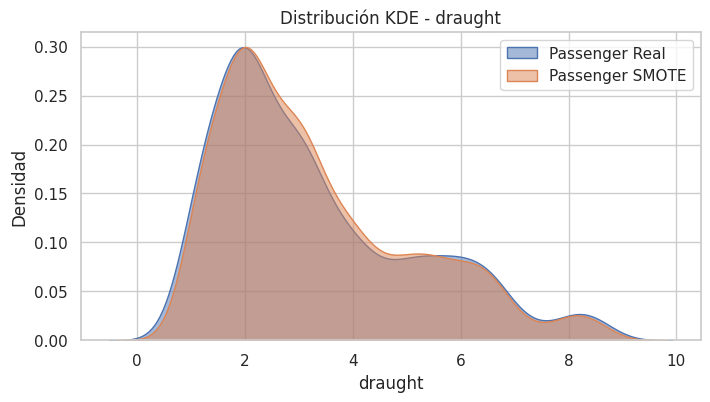

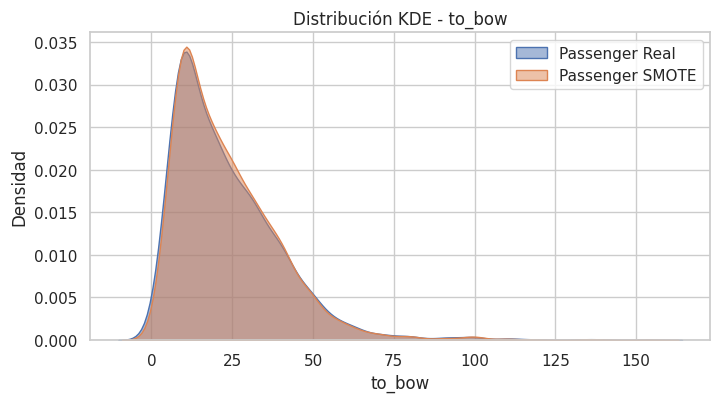

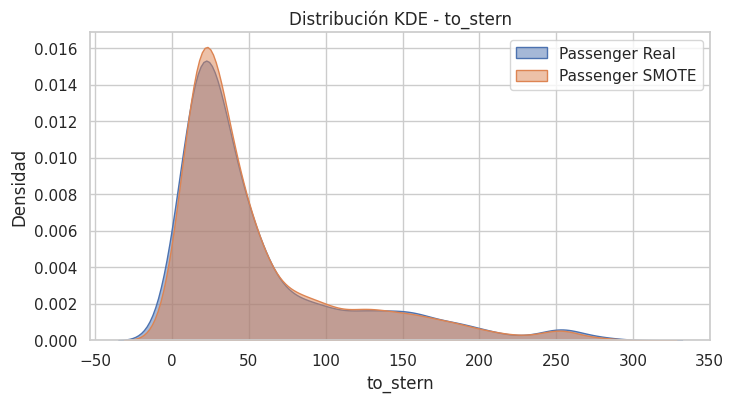

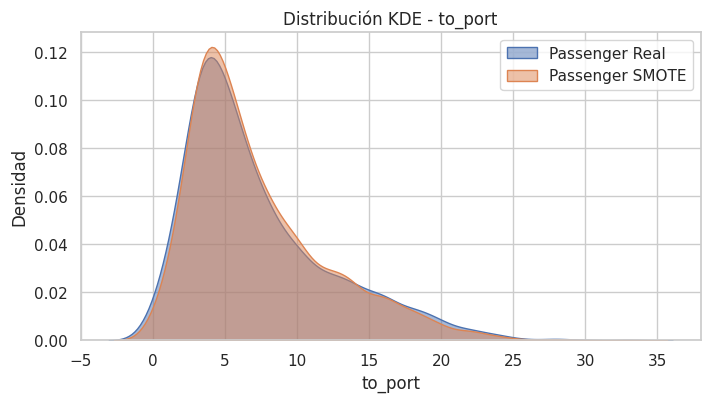

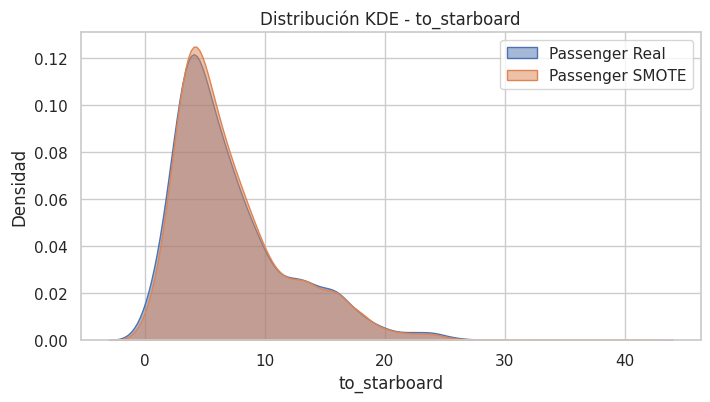

In [34]:
# Graficar curvas KDE

sns.set(style="whitegrid")

for var in variables_numericas:
    real_vals = real_passenger[var].dropna()
    smote_vals = augmented_passenger[var].dropna()

    if real_vals.nunique() > 1 and smote_vals.nunique() > 1:
        plt.figure(figsize=(8, 4))
        sns.kdeplot(real_vals, label='Passenger Real', fill=True, alpha=0.5)
        sns.kdeplot(smote_vals, label='Passenger SMOTE', fill=True, alpha=0.5)
        plt.title(f'Distribución KDE - {var}')
        plt.xlabel(var)
        plt.ylabel('Densidad')
        plt.legend()
        plt.show()



📈 AUC-ROC binario para clase Passenger: 0.9687


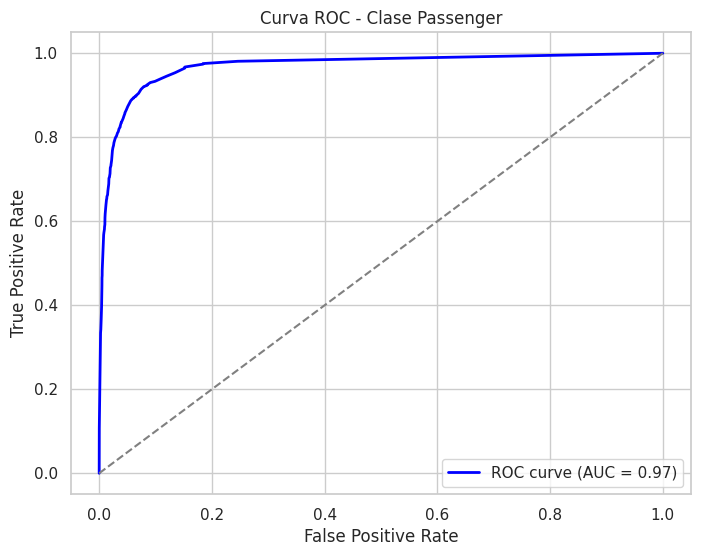

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


# Separar train y test desde df_real
df_train, df_test = train_test_split(df_real, random_state=43)

x_train = df_train.drop(columns=['shiptype', 'MMSI'])
y_train = (df_train['shiptype'] == 'Passenger').astype(int)

x_test = df_test.drop(columns=['shiptype', 'MMSI'])
y_test = (df_test['shiptype'] == 'Passenger').astype(int)

# Pipeline: escalado + RandomForest
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entrenar y predecir
model = pipe.fit(x_train, y_train)
y_score = model.predict_proba(x_test)[:, 1]

# Calcular curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
auc_passenger = auc(fpr, tpr)

print(f"\n📈 AUC-ROC binario para clase Passenger: {auc_passenger:.4f}")

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_passenger:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clase Passenger')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


📉 AUC-ROC binario para clase Passenger (SMOTE): 0.9756


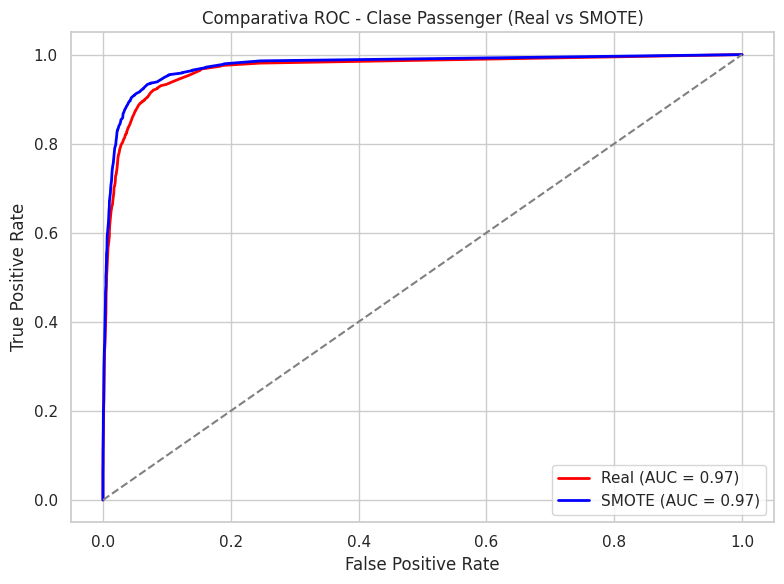

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score

# Separar train y test desde df_synth (SMOTE)
df_train_s, df_test_s = train_test_split(df_synth, random_state=43)

x_train_s = df_train_s.drop(columns=['shiptype', 'MMSI'])
y_train_s = (df_train_s['shiptype'] == 'Passenger').astype(int)

x_test_s = df_test_s.drop(columns=['shiptype', 'MMSI'])
y_test_s = (df_test_s['shiptype'] == 'Passenger').astype(int)

# Pipeline
pipe_s = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entrenar modelo
model_s = pipe_s.fit(x_train_s, y_train_s)
y_score_s = model_s.predict_proba(x_test_s)[:, 1]

# Calcular curva ROC y AUC
fpr_s, tpr_s, _ = roc_curve(y_test_s, y_score_s)
auc_passenger_s = auc(fpr_s, tpr_s)

print(f"\n📉 AUC-ROC binario para clase Passenger (SMOTE): {auc_passenger_s:.4f}")

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'Real (AUC = {auc_passenger_r:.2f})')
plt.plot(fpr_s, tpr_s, color='blue', lw=2, label=f'SMOTE (AUC = {auc_passenger:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparativa ROC - Clase Passenger (Real vs SMOTE)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
